# Project Description 

Here is a short project description; This notebook is fictitious to illustrate common data analysis tasks. Intention here is to use this as a tempate for data classification work.

This **project1** will:

* load a sample dataset and explore the loaded data
* Prepares the Dataset by removing columns, filtering rows
* Show some descriptive stats on the data
* Show Inferential Statistics using Classification 
* provides results of the analysis 


### Description of the Dataset

> The dataset contains various columns extracted from device Census for specifically for OEM Models matching {**Surface Pro 4 **  ** Surface Book ** }

> The "Capable" Columns indicates whether that device is "Hello Capable" or not. 

> We know that all Surface pro 4 (include Surface Book) devices are hard ware ready and they become capable when suitable software drivers are installed 

> The task here is to detect if a device is "Hello capable or not"

> This problem is artificially made up for the purpose of creating this template and no animals are hurt during this production :)

In [1]:
%%time
#%run "../PyUtils/common.ipynb"

import sys
import importlib as imp
if ('Jupytils' in sys.modules):
    reloaded = imp.reload(Jupytils)
else:
    import Jupytils
    
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcess
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import ensemble
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
#from statsmodels.regression.quantile_regression import QuantReg
#import statsmodels.formula.api as smf
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

han1="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20patient_data_table";
hand="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20hand"
kimj="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20kimj";
leeh="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20leeh";
sony="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20sony";
kuky="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20kuky";

fileName = hand;

dfOriginal = LoadDataSet(fileName, checkForDateTime=False);
displayDFs (dfOriginal, maxrows=3 );
#for c in dfOriginal.columns: print (c,  end=', ')

fileName="data/analysis1.xlsx"  # Data is located in analysis1.xlsx
fileName="data/analysis1-small.xlsx"  # Data is located in analysis1.xlsx
dfOriginal = LoadDataSet(fileName, columns=None, checkForDateTime=False);

# Filename can be 
#     1. URL: fileName="https://raw.githubusercontent.com/pydata/pandas/master/pandas/tests/data/iris.csv"
#     2. csv, tsv or excel spread sheet (Database is not supported now)
#     3. It can be string with new lines

#analysis1.xlsx         - contains approx 1 million rows - therefore takes aout 2 minutes to load
#analysis1-small.xlsx   - contains approx 400 rows - I will use this first to test and switch to bigger file later 


#Explore the loaded data by uncommenting the following code 

print (dfOriginal.columns)
# -- Above will give:
# Index([u'ProcessedDateId', u'DeviceId', u'OEMModel', u'OSVersionFull', u'OSVersionToStr', u'FirstUpdatedDate',  
#        u'LastUpdatedDate', u'IngestTime', u'OSInstallDate',  u'FirstSeen', u'Capable_FirstSeen', u'AuthType', u'DBKLag',
#        u'DBKLagOSInstallDate', u'DBKLagFirstUpdatedDate', u'DBKLagFirstLastUpdatedDate', u'Capable'], dtype='object')
#
# 
displayDFs(dfOriginal)
# -- This will display raw data as is

This will load or reload Jupytils; This message in Future Versions 

<IPython.core.display.Javascript object>

/Users/snarayan/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Index(['ProcessedDateId', 'DeviceId', 'OEMModel', 'OSVersionFull', 'OSVersionToStr', 'FirstUpdatedDate', 'LastUpdatedDate', 'IngestTime', 'OSInstallDate', 'FirstSeen', 'Capable_FirstSeen', 'AuthType', 'DBKLag', 'DBKLagOSInstallDate', 'DBKLagFirstUpdatedDate', 'DBKLagFirstLastUpdatedDate', 'Capable'], dtype='object')


CPU times: user 12.1 s, sys: 450 ms, total: 12.6 s
Wall time: 13 s


In [11]:
# Prepare dataset
#
# 1. Drop columns we don't need
# 2. Convert column datatypes as needed; to string, datetime, numbers as needed
# 3. Add Calculated Columns
# 4. Filter out rows and reindex the dataframe
# 5. Display the resulting dataframe
# 6. Show some descriptive statistics

#=====
#1. "ProcessedDateId" column is Intentionally misspelled to show it goes undetected if not careful

toDrop= [k.strip() for k in '''ProcessedDateId1, DeviceId, OSVersionFull,IngestTime,AuthType, FirstUpdatedDate, FirstSeen,DBKLagFirstUpdatedDate, DBKLagFirstLastUpdatedDate '''.split(",")]
dfL = dfOriginal.drop(toDrop, axis=1, errors="ignore")

#1a -> Set the Prediction column
#   -> Set class names if you know it or make it None
predictColumn = "Capable"
class_names = ["Not capable", "Capable"]

#2. Some wrong dates causing error here - so lets treat this as str
dfL[u'Capable_FirstSeen'] = dfL[u'Capable_FirstSeen'].astype(str)    # Treat this columns as string
dfL[u'ProcessedDateId']   = dfL[u'ProcessedDateId'].astype(str)      # Treat this columns as string (intentionally included)


#3. Calculated columns
dfL[u'DBKLag'] = dfL[u'DBKLag']/60                                   # lets divide this by 60 
dfL[u'DBKLag'] = dfL.DBKLag.apply(abs)                               # Convert to absolute value 
#
# Add a today's column 
# Convert to datetime - although it is already in datetime format
dfL['today'] = datetime.datetime.today()
dfL.LastUpdatedDate  = pd.to_datetime(dfL.LastUpdatedDate)
#
# calculate the hours difference between today and last updated Date
dfL['diff_last_to_today'] = (dfL.today - dfL.LastUpdatedDate) / np.timedelta64(1, 'h'); 

#4. Filter rows
n1 = dfL.shape[0]
dfL = dfL[dfL.DBKLag > 1]                                            # Lets take only those that have a value > 0 
#
# Here are other common filtering you may use:
# dfL = dfL[dfL['OEMModel'] == "Surface Pro 4"]
# dfL = dfL[dfL.OSVersionFull.str.contains("th1") | dfL.OSVersionFull.str.contains("th2")]

n2 = dfL.shape[0]
print ("Filtering: Number of rows Before {} and After {}".format(n1,n2));

#4a. You may reshuffle the rows if needed to make sure they are not in any particular order
dfL = dfL.sample(frac=1).reset_index(drop=True)

#4b. 
# Once you filter, it is a good idea to reindex such that 0th row matches to 0th row in the resulting dataframe
# To see what happens if you didn't to reindex, comment out the following code and notice index 1 and 3 are visibly missing 

dfL = dfL.reset_index(drop=True) 

#5.
displayDFs(dfL, showIcons=True, showStats=False, maxrows = 4) ;

# You can see the entire dataframe by using the following
# HTML(dfL.to_html())


Filtering: Number of rows Before 400 and After 248


In [3]:
# You can even view the Excel spread sheet if you wanted to:
# Excel2Html(fileName, length="300px")


## Descriptive Statistics

Dropping in prepareDF -  Index(['ProcessedDateId', 'Capable_FirstSeen'], dtype='object')


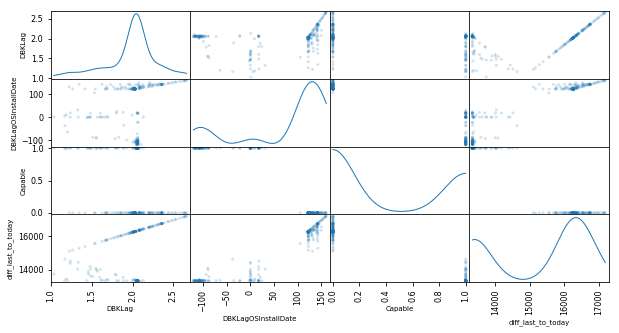

In [4]:
#6. Descriptive statistics 
# In above we see individual stats per column; here we see the interaction between columns

df =  prepareDF(dfL, makeCopy=True)
scatter_matrix(dfL, alpha=0.2, diagonal='kde', figsize=(10, 5)); # diagonal can be 'hist';

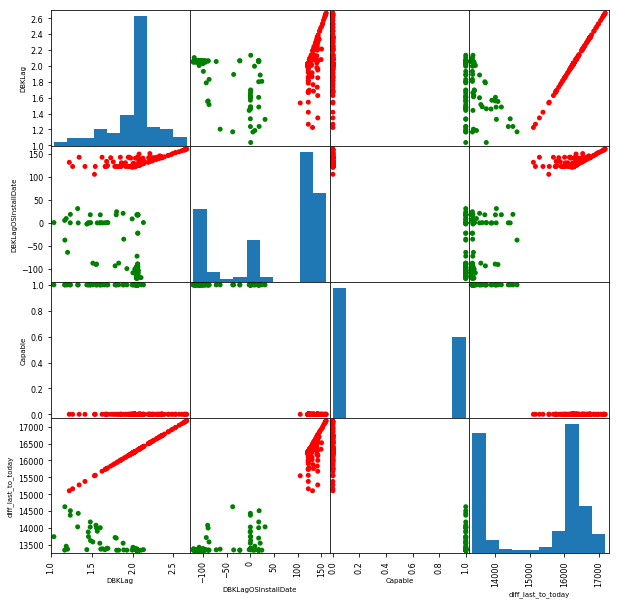

In [5]:
# or see the ditribution of target variable based opn colors and histograms

c="r,g,b,c,m,y,k,w".split(",")
scatter_matrix(dfL, alpha=1, figsize=(10,10), s=100, c=df[predictColumn].apply(lambda x:c[x]));

# 6a. Cross tab calculations


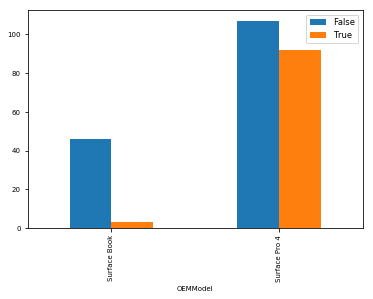

In [6]:
print ("# 6a. Cross tab calculations")
d=pd.crosstab(dfL.OEMModel, dfL[predictColumn].astype(bool))
d.plot(kind="bar")
HTML(d.to_html())

plt.legend(loc='upper right');

#6b lets see the distribution of DBKLag pivotting on [predictColumn] flag


''

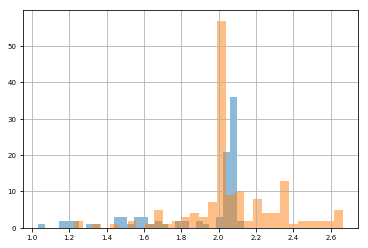

In [7]:
print ("#6b lets see the distribution of DBKLag pivotting on [predictColumn] flag")

dfs = [dfL[dfL[predictColumn] == k] for k in dfL[predictColumn].unique() ] 

interestingColumns=['DBKLag']
for d in dfs:
    for i in interestingColumns:
        d[i].hist(alpha=0.5, bins=30, label=d[predictColumn], grid=True)
;

#6b PCA and view scatter plot on 2D
Dropping in prepareDF -  Index(['ProcessedDateId', 'Capable_FirstSeen'], dtype='object')


,0,1,Capable,Capable_idx
0,8837565537.863,-1758174707.195,1,1
1,-4136562612.164,-569203803.448,0,0
2,-4112163197.815,-567143732.279,0,0
3,8774248601.756,-1682069670.046,1,1
...,...,...,...,...
244,8840757691.850,-1762023103.892,1,1
245,-4102060764.642,-571753848.370,0,0
246,-3971595554.811,-575218465.899,0,0
247,8842034903.530,-1763562171.941,1,1


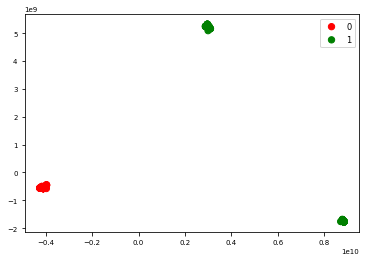

In [8]:
print ("#6b PCA and view scatter plot on 2D")

PCAPlot(dfL, predictColumn)

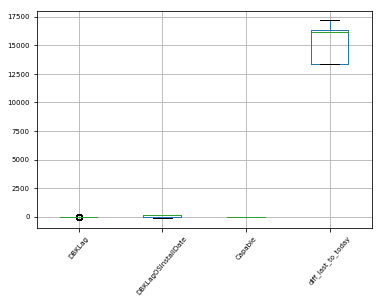

In [9]:
# Review the box plot of the resulting dataframe
#
dfL.boxplot(figsize=(1150,1150), rot=50 , return_type='axes');

## Predictive Analytics

In [10]:
# Lets convert the columns to numeric 
# Please see Prepare in Features.py 

df =  prepareDF(dfL, makeCopy=True)

# After you run this, this will remove ProcessDateId column since it seems like a key column
# Review the resulting final data set;
display(dfL.head(), "==>" ,df.head() )

# shuffle the rows so that it won't cause hidden problems in case
df = df.sample(frac=1).reset_index(drop=True)


Dropping in prepareDF -  Index(['ProcessedDateId', 'Capable_FirstSeen'], dtype='object')


,ProcessedDateId,OEMModel,OSVersionToStr,LastUpdatedDate,OSInstallDate,Capable_FirstSeen,DBKLag,DBKLagOSInstallDate,Capable,today,diff_last_to_today
0,20160225,Surface Pro 4,10586.00104.160126.1819,2016-02-25 14:57:56,2016-02-04,2015-10-24 19:00:00,2.064,-102.208,1,2017-09-03 11:23:33.441908,13340.427
1,20151002,Surface Book,10240.16498.150819.1946,2015-10-02 08:50:35,2015-10-02,nan,2.438,146.673,0,2017-09-03 11:23:33.441908,16850.550
2,20151022,Surface Pro 4,10240.16498.150819.1946,2015-10-22 17:42:19,2015-10-16,nan,2.099,132.673,0,2017-09-03 11:23:33.441908,16361.687
3,20160225,Surface Pro 4,10586.00104.160126.1819,2016-02-25 04:05:07,2016-01-05,2015-10-24 21:00:00,2.055,-72.125,1,2017-09-03 11:23:33.441908,13351.307
4,20151007,Surface Pro 4,10240.16520.150916.2039,2015-10-07 01:22:38,2015-10-06,nan,2.360,142.673,0,2017-09-03 11:23:33.441908,16738.015


'==>'

,OEMModel,OSVersionToStr,LastUpdatedDate,OSInstallDate,DBKLag,DBKLagOSInstallDate,Capable,today,diff_last_to_today
0,1,14,20160225145756,20160204000000,2.064,-102.208,1,20170903112333,13340.427
1,0,1,20151002085035,20151002000000,2.438,146.673,0,20170903112333,16850.550
2,1,1,20151022174219,20151016000000,2.099,132.673,0,20170903112333,16361.687
3,1,14,20160225040507,20160105000000,2.055,-72.125,1,20170903112333,13351.307
4,1,2,20151007012238,20151006000000,2.360,142.673,0,20170903112333,16738.015


In [ ]:
%%time
cls = [# Comment/uncomment out any classfiers according to your need 
       # DO NOT CHANGE
        "DecisionTree Gini" , tree.DecisionTreeClassifier(max_depth=4, criterion="gini"),
        "DecisionTree Entr" , tree.DecisionTreeClassifier(max_depth=4, criterion="entropy"), 
        #"SVM"               , sklearn.svm.SVC(), 
        #"Random Forest"     , sklearn.ensemble.RandomForestClassifier(),
        "K-NN"              , sklearn.neighbors.KNeighborsClassifier(),
        "Gradient Boosting" , sklearn.ensemble.RandomForestClassifier(),
        "Logit Regression"  , sklearn.linear_model.LogisticRegression()
];

y = df[predictColumn]
X = df.drop(predictColumn, axis=1)
Classify(X,y, drawConfusionMatrix=False, classifiers=cls, scale=False, printDebug=False)

In [ ]:
%run "../common.ipynb"
decisionTrees = []

for k in range( int(len(cls)/2)):
    d = cls[k*2+1];
    if (str(type(d)).find('DecisionTreeClassifier') > 0):
        decisionTrees.append(cls[k*2])
        decisionTrees.append(cls[k*2+1])

d = DrawDecisionTree(X,y, decisionTrees, class_names);


In [ ]:
%run "../common.ipynb"
# Lets run the decision tree by removing the most significant feature to see 
#  which other features bubbles up in the significance list

for i in range(min(5, len(X.columns)-1) ) :
    mostSignificant=np.argsort(decisionTrees[1].feature_importances_)[-1]
    c = X.columns[mostSignificant]
    print ("***********", i, ": Most Significant Column is: ", c)
    #HTML("<h2> Dropping column and running next </h2><hr>")
    X = X.drop(c, axis=1)
    (X1,y1,ra,cls) = Classify(X,y, True, drawConfusionMatrix=True, classifiers=decisionTrees, scale=False)
    DrawDecisionTree(X,y, cls, class_names)

## Results

> Present conclusions Here